In [1]:
from packages.display.core import *
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 5)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
%qtconsole

# ALMA Cycle 0

https://www.iram.fr/IRAMFR/ARC/documents/cycle0/ALMA_EarlyScience_Cycle0_HighestPriority.pdf

## 	Project 2011.0.00772.S

### 	2011.0.00115.S_2013-02-19_033_of_033

Resq Freq 115.271 MHz

In [40]:
file_path = 'data/calibrated.ms.contsub.bin4.line.image.fits'
train_pixel = (425, 700)
noise_pixel = (250, 171)

In [ ]:
img = fits.open(file_path)

meta = img[0].data
hdr = img[0].header

# V axis
naxisv = hdr['NAXIS3']

onevpix = hdr['CDELT3']*0.000001
v0 = hdr['CRVAL3']*0.000001
v0pix = int(hdr['CRPIX3'])
vaxis = onevpix * (np.arange(naxisv)+1-v0pix) + v0

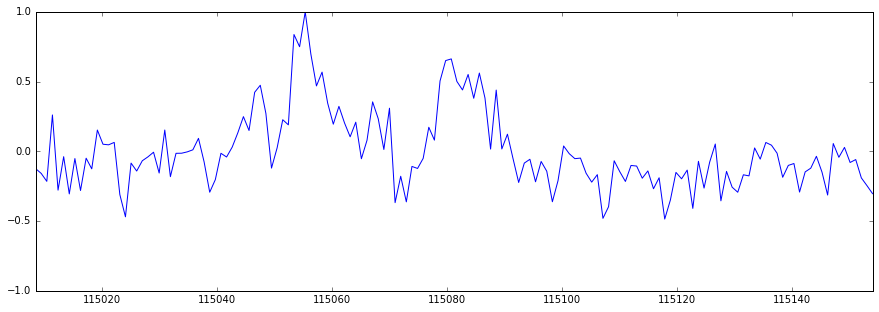

In [47]:
values = meta[0, :, train_pixel[0], train_pixel[1]] - np.mean(meta[0, :, train_pixel[0], train_pixel[1]])
values = values/np.max(values)

plt.plot(vaxis, values)

plt.ylim(-1, 1)
plt.xlim(np.min(vaxis), np.max(vaxis))
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

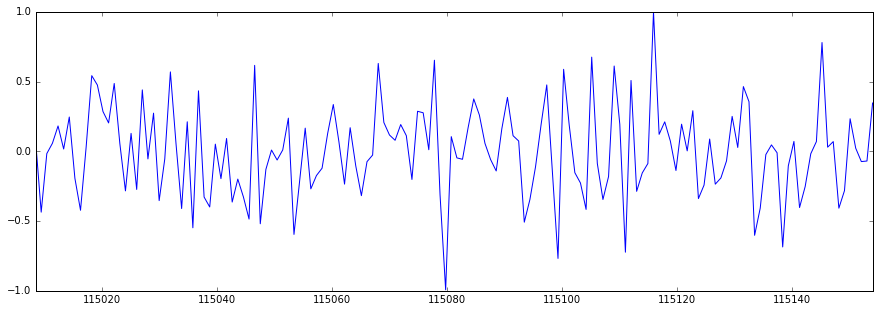

In [41]:
noise = meta[0, :, noise_pixel[0], noise_pixel[1]] - np.mean(meta[0, :, noise_pixel[0], noise_pixel[1]])
noise = noise/np.max(noise)

plt.plot(vaxis, noise)

plt.ylim(-1, 1)
plt.xlim(np.min(vaxis), np.max(vaxis))
gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))

To select the isolist, the wavelength range of the cube is obtained, and a searching from theoretical catalog Splatalogue is performed. All the isotopes that have spectral lines on the range of the cube are determinated.

In [42]:
freq_init = vaxis[0]
freq_end = vaxis[-1]

dbpath = 'ASYDO'
dba = packages.asydopy.db.lineDB(dbpath)
dba.connect()
select = "SELECT * FROM Lines WHERE NOT SPECIES LIKE '%-%' AND FREQ > " + str(freq_init) + " AND FREQ < " + str(freq_end)
molist_present = dba.executeSQL(select)
dba.disconnect()

## Creation of Dictionary

We create the words necessary to fit a sparse coding model to the observed spectra in the previous created cube.
It returns a DataFrame with a vector for each theoretical line for each isotope in molist

In [43]:
cube_params = {
  'freq'     : vaxis[len(vaxis)/2],
  'alpha'    : 0,
  'delta'    : 0,
  'spe_bw'   : naxisv,
  'spe_res'  : v0pix,
  's_f'      : 8,
  's_a'      : 0}

log = sys.stdout
dbpath = 'ASYDO'
dictionary = pd.DataFrame([])

last_code = ""
last_freq = 0

for tuple in molist_present:
    iso = tuple[1]
    univ=packages.display.vu.Universe(log)
    univ.create_source('word-'+ iso)
    s_x = 1
    s_y = 1
    rot = 0
    s_f=cube_params['s_f']
    angle=math.pi
    model=packages.display.vu.IMCM(
        log,dbpath,iso,temp,
        ('normal',s_x, s_y, angle),
        ('skew', cube_params['s_f'], cube_params['s_a']),
        ('linear', angle, rot))
    model.set_radial_velocity(rvel)
    univ.add_component('word-'+ iso, model)
    lines = univ.gen_cube('observerd',
                          cube_params['freq'],
                          cube_params['spe_res'],
                          cube_params['spe_bw'])
    if len(lines.hdulist) > 1:

        for line in lines.hdulist[1].data:

            last_iso = last_code.split('-')[0]
            distance = float(line[0].split('-')[1][1:]) - last_freq

            if(iso != last_iso or \
             (iso == last_iso and distance >= 1)):

                word = np.array(np.zeros(len(lines.get_spectrum())))
                '''
                    line[0] : line_code alias
                    line[1] : relative freq at the window
                '''
                word[line[1]] = 1
                dictionary[line[0]] = word

                last_code = line[0]

            else:
                #
                dictionary.pop(last_code)
                word[line[1]] = 1
                # dictionary[line[0]] = word

                dual_alias = last_code + "&&" + \
                             line[0].split('-')[1]
                #
                dictionary[dual_alias] = word
                # dictionary[dual_alias] = np.sum([dictionary\
                #                     [last_code], word], axis=0)
                # if '&&' in last_code:
                #     dictionary.pop(last_code)

                last_code = dual_alias

            last_freq = float(line[0].split('-')[1][1:])

dictionary.index = get_freq_index_from_params(cube_params)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Recalibration of Dictionary

In [44]:
dictionary_recal, detected_peaks = recal_words(file_path, dictionary, cube_params, 
                                               train_pixel, noise_pixel)

X = get_values_filtered_normalized(file_path, train_pixel, cube_params)

y_train = get_fortran_array(np.asmatrix(X))
dictionary_recal_fa = np.asfortranarray(dictionary_recal,
                                        dtype= np.double)

lambda_param = 0
for idx in range(0, len(detected_peaks)):
    if detected_peaks[idx] != 0:
        lambda_param += 1

param = {
  'lambda1' : lambda_param,
  # 'L': 1,
  'pos' : True,
  'mode' : 0,
  'ols' : True,
  'numThreads' : -1}

alpha = spams.lasso(y_train, dictionary_recal_fa, **param).toarray()
total = np.inner(dictionary_recal_fa, alpha.T)

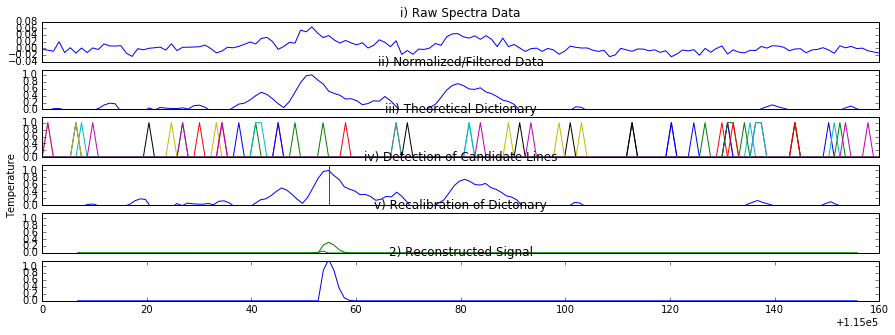

In [45]:
x = get_freq_index_from_params(cube_params)

# Step 1: Read Cube
ax = plt.subplot(6, 1, 1)
ax.set_title('i) Raw Spectra Data')
data = get_data_from_fits(file_path)  
y = data[0, :, train_pixel[0], train_pixel[1]]
plt.xticks([])
plt.plot(x, y)
lines = get_lines_from_fits(file_path)
for line in lines:
    # Shows lines really present
    isotope_frequency = int(line[1])
    isotope_name = line[0] + "-f" + str(line[1])
    plt.axvline(x=isotope_frequency, ymin=0, ymax= 3, color='g')

# 2. Normalize, filter dada
ax = plt.subplot(6, 1, 2)
ax.set_title('ii) Normalized/Filtered Data')
plt.ylim(ymin =0,ymax = 1.15)
y = get_values_filtered_normalized(file_path, train_pixel, cube_params)
plt.xticks([])
plt.plot(x, y)

# 3. Possible Words
ax = plt.subplot(6, 1, 3)
ax.set_title('iii) Theoretical Dictionary')
plt.ylim(ymin =0,ymax = 1.15)
plt.xticks([])
plt.plot(x, dictionary)

# 4. Detect Lines
ax = plt.subplot(6, 1, 4)
ax.set_title('iv) Detection of Candidate Lines')
plt.ylim(ymin =0,ymax = 1.15)
plt.plot(x, y)
plt.xticks([])
plt.ylabel("Temperature")
for idx in range(0, len(detected_peaks)):
    if detected_peaks[idx] != 0:
        plt.axvline(x=x[idx], ymin=0, ymax= 1, color='r')

# 6. Recalibrate Dictionary
ax = plt.subplot(6, 1, 5)
ax.set_title('v) Recalibration of Dictonary')
plt.ylim(ymin =0,ymax = 1.15)
plt.plot(x, dictionary_recal_fa)
plt.xticks([])

# 6. Recover Signal
ax = plt.subplot(6, 1, 6)
ax.set_title('2) Reconstructed Signal')
plt.ylim(ymin =0,ymax = 1.15)

plt.plot(x, total)




In [49]:
dictionary.columns[alpha[:, 0] > 0]

Index([u'CH3C5N-f115056.9082&&f115056.9109&&f115056.9111'], dtype='object')